# Build Figures


Created: 4/11/2021

Author:  Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd
import glob, re, pprint, random
from datetime import datetime
import pprint

from scipy.stats import pearsonr, ttest_ind
from scipy.signal import savgol_filter
from scipy import interpolate

from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt

from src.formation import FormationCell
from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

GREY = (0.9, 0.9, 0.9)

## Load resources

In [5]:
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    
    if cellid == 9:
        continue
        
    cell_dict[cellid] = FormationCell(cellid)

## Concept Illustration

In [6]:
df_base_form = cell_dict[CELL_BASE].get_formation_data()
df_fast_form = cell_dict[CELL_FAST].get_formation_data()

df_base_form = df_base_form[df_base_form['Test Time (s)'] > 86400]
df_fast_form = df_fast_form[df_fast_form['Test Time (s)'] > 86400]

(-1.0, 65.0)

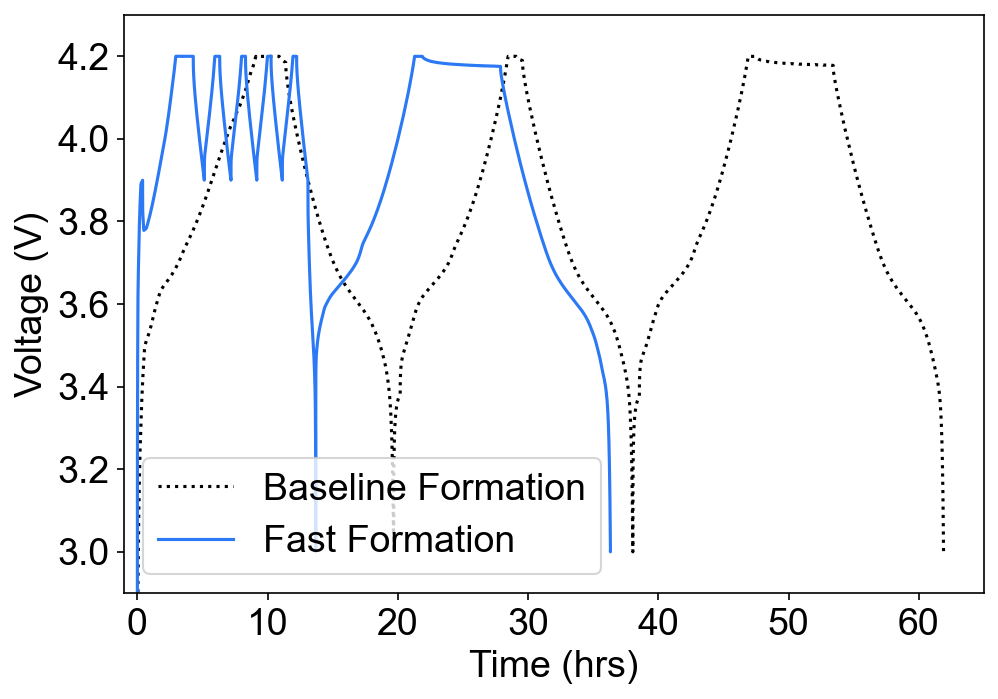

In [7]:
plt.figure()

plt.plot((df_base_form['Test Time (s)'] - 86400)/3600, df_base_form['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_form['Test Time (s)'] - 86400)/3600, df_fast_form['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline Formation', 'Fast Formation'], frameon=True)
plt.ylim((2.9, 4.3))
plt.xlim((-1, 65))


In [8]:
df_base_rpt = cell_dict[CELL_BASE].get_aging_data_timeseries()
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] < 5]
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] > 1]

df_fast_rpt = cell_dict[CELL_FAST].get_aging_data_timeseries()
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] < 5]
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] > 1]

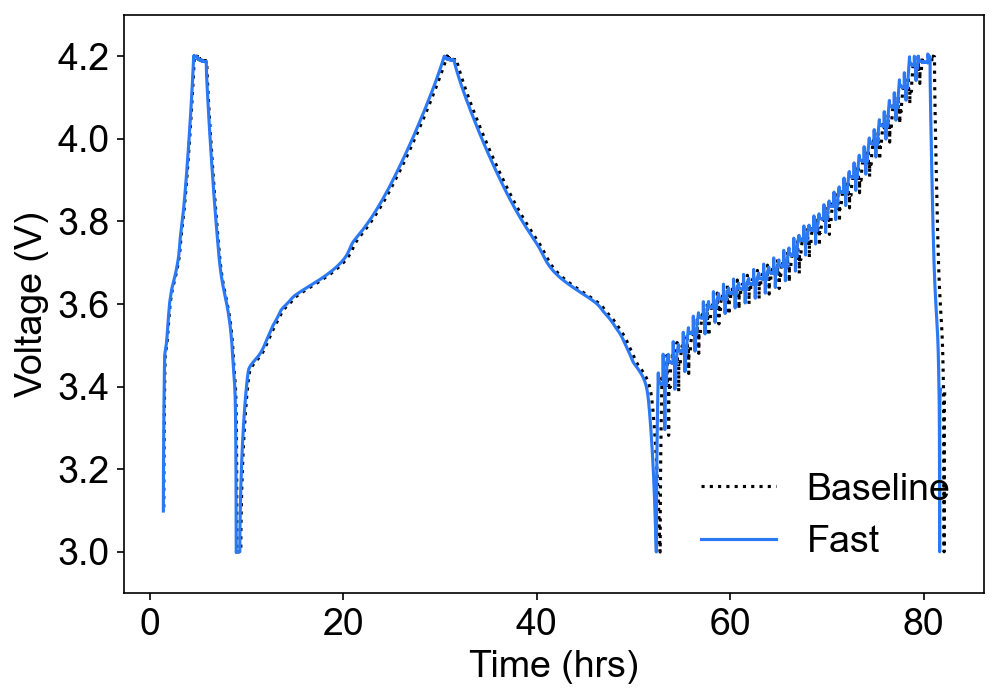

In [9]:
plt.subplot()

plt.plot(df_base_rpt['Test Time (s)'] / 3600, df_base_rpt['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_rpt['Test Time (s)'] / 3600, df_fast_rpt['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.ylim((2.9, 4.3))
plt.legend(['Baseline', 'Fast'], frameon=False)

(0.8, 2.4)

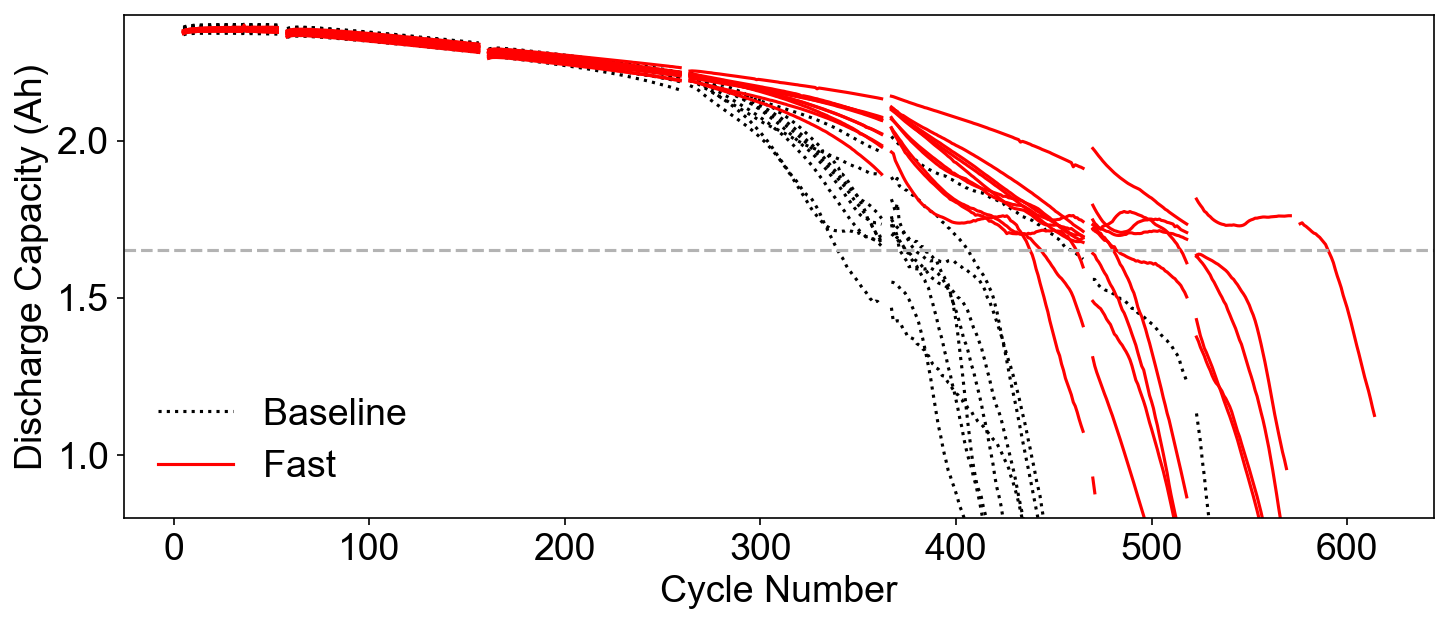

In [10]:
plt.figure(figsize=(10, 4.5))

for cellid, cell in cell_dict.items():
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_HT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df = df.copy()
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)
    
plt.plot(np.nan, np.nan, label='Baseline ',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast ',
        color=COLOR_FAST_HT, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
        color=COLOR_REF, linestyle='--')
plt.legend(loc=3, frameon=False)
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

(0.8, 2.4)

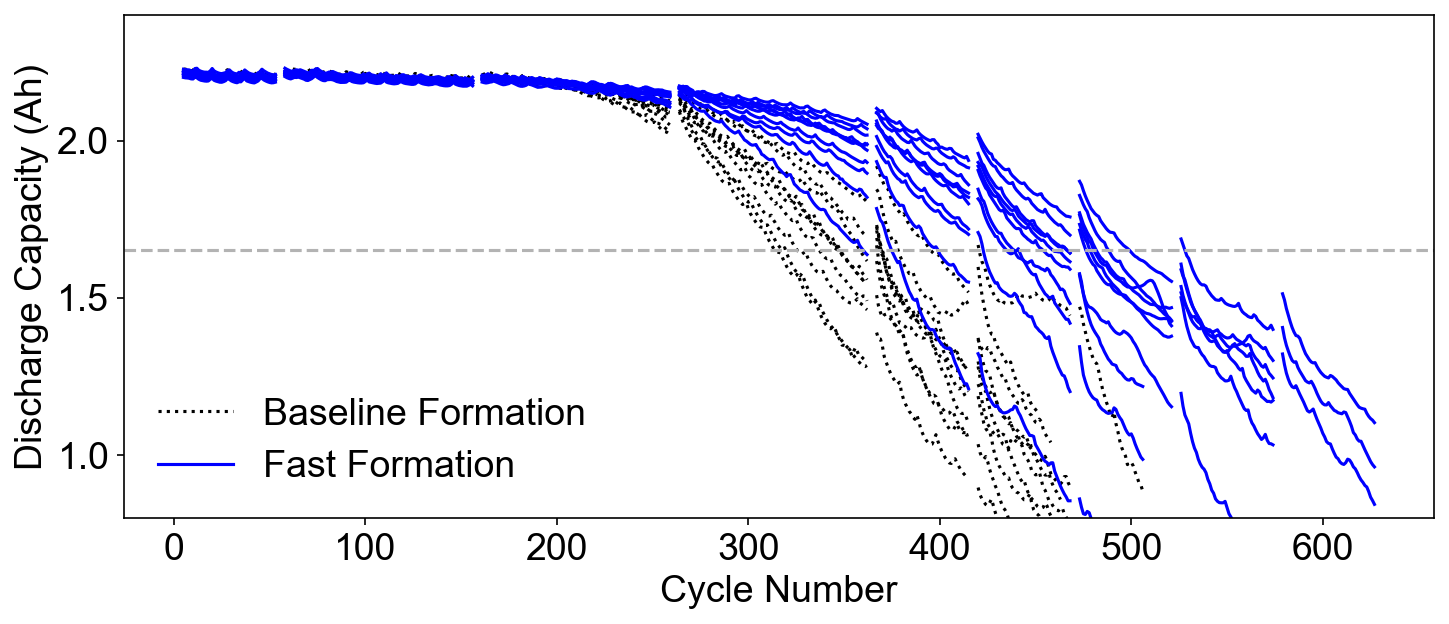

In [11]:
plt.figure(figsize=(10, 4.5))

for cellid, cell in cell_dict.items():
        
    if not cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_RT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)

plt.plot(np.nan, np.nan, label='Baseline Formation',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast Formation',
        color=COLOR_FAST_RT, linestyle=LINESTYLE_FAST)
plt.legend(loc=3, frameon=False)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
            color=COLOR_REF, linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

### Resistance vs SOC Maps

Working on cell 1...
Working on cell 2...
Working on cell 3...
Working on cell 4...
Working on cell 5...
Working on cell 6...
Working on cell 7...
Working on cell 8...
Working on cell 10...
Working on cell 11...
Working on cell 12...
Working on cell 13...
Working on cell 14...
Working on cell 15...
Working on cell 16...
Working on cell 17...
Working on cell 18...
Working on cell 19...
Working on cell 20...
Working on cell 21...
Working on cell 22...
Working on cell 23...
Working on cell 24...
Working on cell 25...
Working on cell 26...
Working on cell 27...
Working on cell 28...
Working on cell 29...
Working on cell 30...
Working on cell 31...
Working on cell 32...
Working on cell 33...
Working on cell 34...
Working on cell 35...
Working on cell 36...
Working on cell 37...
Working on cell 38...
Working on cell 39...
Working on cell 40...


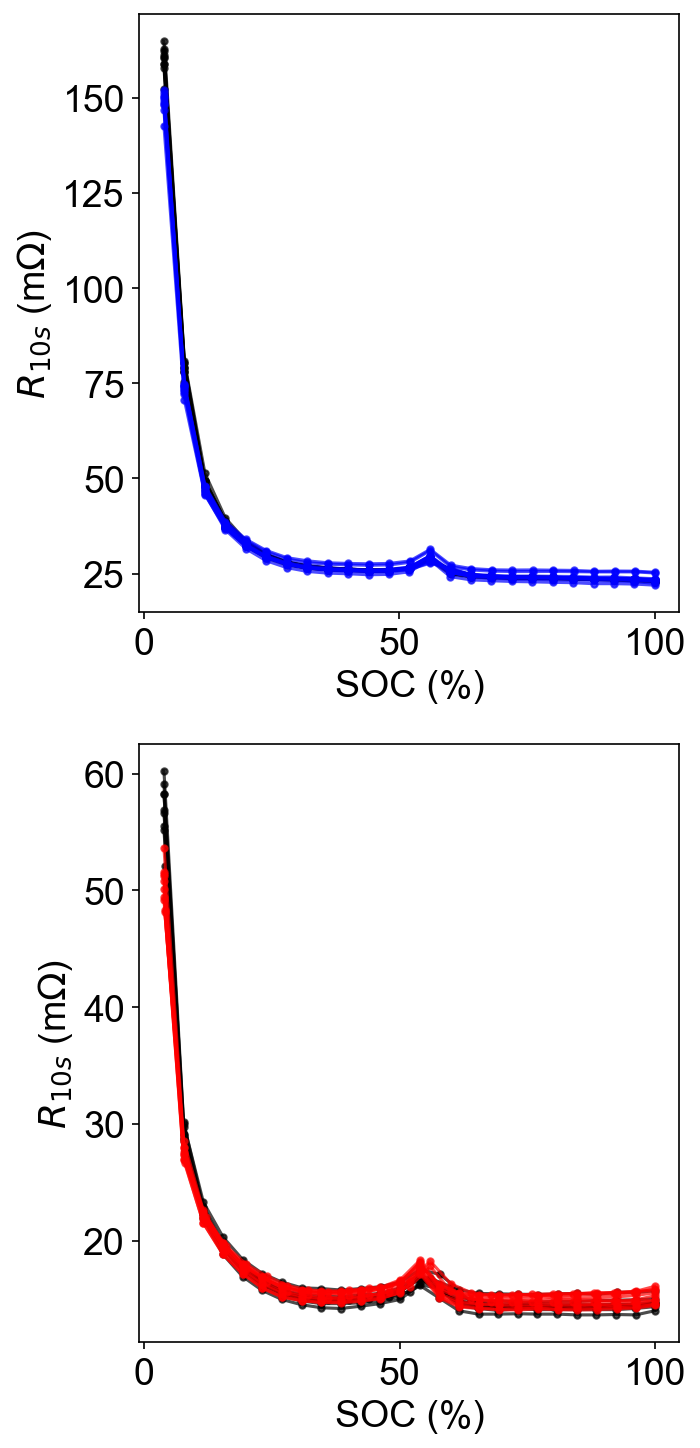

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

for cellid, cell in cell_dict.items():
        
#     if cellid != CELL_BASE and cellid != CELL_FAST and cellid != 26 and cellid != 15:
#         continue
        
        
    print(f"Working on cell {cellid}...")
        
    ax = axs[0] if cell.is_room_temp() else axs[1]
    
    hppc_dict = cell.process_diagnostic_hppc_data()
        
    cap = hppc_dict[0]['data']['capacity']
    dcr = hppc_dict[0]['data']['resistance_10s_ohm']*1000
    
    soc = cap/np.max(cap)*100
        
    color = (0, 0, 1) if cell.is_room_temp() else (1, 0, 0)
    color = (0, 0, 0) if cell.is_baseline_formation() else color
    
    ax.plot(soc, dcr, color=color, marker='o', markersize=3, alpha=0.70)
    
#     ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100])
#     ax.set_xlim((3, 10))
    
[ax.set(ylabel='$R_{10s}$ (m$\Omega$)') for ax in axs]
[ax.set(xlabel='SOC (%)') for ax in axs]
[ax.grid(False) for ax in axs]

plt.show()

In [13]:
# Get the data
results_list = []

for cellid, cell in cell_dict.items():
    
    print(f'Processing cell {cell}...')

    stats_dict = cell.get_aging_test_summary_statistics()

    for retention in np.array([50, 60, 70, 80]):

        curr_dict = dict()
        curr_dict['cellid'] = cell.cellid
        curr_dict['is_room_temp'] = cell.is_room_temp()
        curr_dict['formation_type'] = 'Baseline Formation' if cell.is_baseline_formation() else 'Fast Formation'
        curr_dict['retention'] = retention
        curr_dict['cycles'] = stats_dict[f'cycles_to_{retention}_pct']
            
        results_list.append(curr_dict)
        
df = pd.DataFrame(results_list)
df['retention'] = df['retention'].astype('category')


df_room_temp = df[df['is_room_temp'] == 1]
df_high_temp = df[df['is_room_temp'] == 0]

Processing cell Formation Cell 1...
Processing cell Formation Cell 2...
Processing cell Formation Cell 3...
Processing cell Formation Cell 4...
Processing cell Formation Cell 5...
Processing cell Formation Cell 6...
Processing cell Formation Cell 7...
Processing cell Formation Cell 8...
Processing cell Formation Cell 10...
Processing cell Formation Cell 11...
Processing cell Formation Cell 12...
Processing cell Formation Cell 13...
Processing cell Formation Cell 14...
Processing cell Formation Cell 15...
Processing cell Formation Cell 16...
Processing cell Formation Cell 17...
Processing cell Formation Cell 18...
Processing cell Formation Cell 19...
Processing cell Formation Cell 20...
Processing cell Formation Cell 21...
Processing cell Formation Cell 22...
Processing cell Formation Cell 23...
Processing cell Formation Cell 24...
Processing cell Formation Cell 25...
Processing cell Formation Cell 26...
Processing cell Formation Cell 27...
Processing cell Formation Cell 28...
Processin

In [14]:
df.to_csv('end_of_life_retention.csv')
std_over_mean = lambda x: np.std(x) / np.mean(x)
iqr_over_mean = lambda x: (np.percentile(x, 75) - np.percentile(x, 25)) / np.median(x)
iqr = lambda x: np.percentile(x, 75) - np.percentile(x, 25)
this_df = df.drop(columns=['cellid'])
this_df = this_df.groupby(['is_room_temp', 'formation_type', 'retention']) \
                 .agg(['mean', 'std', std_over_mean, iqr, iqr_over_mean])['cycles']
this_df

mean        std  <lambda_0>  \
is_room_temp formation_type     retention                                      
False        Baseline Formation 50         423.111111  39.001424    0.086906   
                                60         410.111111  37.321055    0.085798   
                                70         379.666667  33.548472    0.083309   
                                80         338.444444  21.880991    0.060954   
             Fast Formation     50         524.200000  45.266618    0.081922   
                                60         511.700000  46.180924    0.085619   
                                70         491.300000  46.212192    0.089234   
                                80         405.400000  31.672631    0.074118   
True         Baseline Formation 50         431.300000  29.299412    0.064447   
                                60         401.700000  36.344188    0.085833   
                                70         364.000000  26.377600    0.068747   
                                80         330.000000  23.981474    0.068942   
             Fast Formation     50         553.100000  58.090829    0.099638   
                                60         522.700000  57.875441    0.105042   
                                70         473.400000  43.858865    0.087892   
                                80         420.400000  37.906904    0.085541   

                                           <lambda_1>  <lambda_2>  
is_room_temp formation_type     retention                          
False        Baseline Formation 50              29.00    0.070388  
                                60              30.00    0.074627  
                                70              19.00    0.050938  
                                80              12.00    0.035714  
             Fast Formation     50              53.00    0.101630  
                                60              56.75    0.111493  
                                70              55.75    0.116146  
                                80              24.00    0.059701  
True         Baseline Formation 50              37.00    0.085648  
                                60              21.50    0.053616  
                                70              31.50    0.085482  
                                80              31.50    0.095890  
             Fast Formation     50              80.50    0.141352  
                                60              72.00    0.132841  
                                70              43.50    0.088957  
                                80              39.50    0.090700

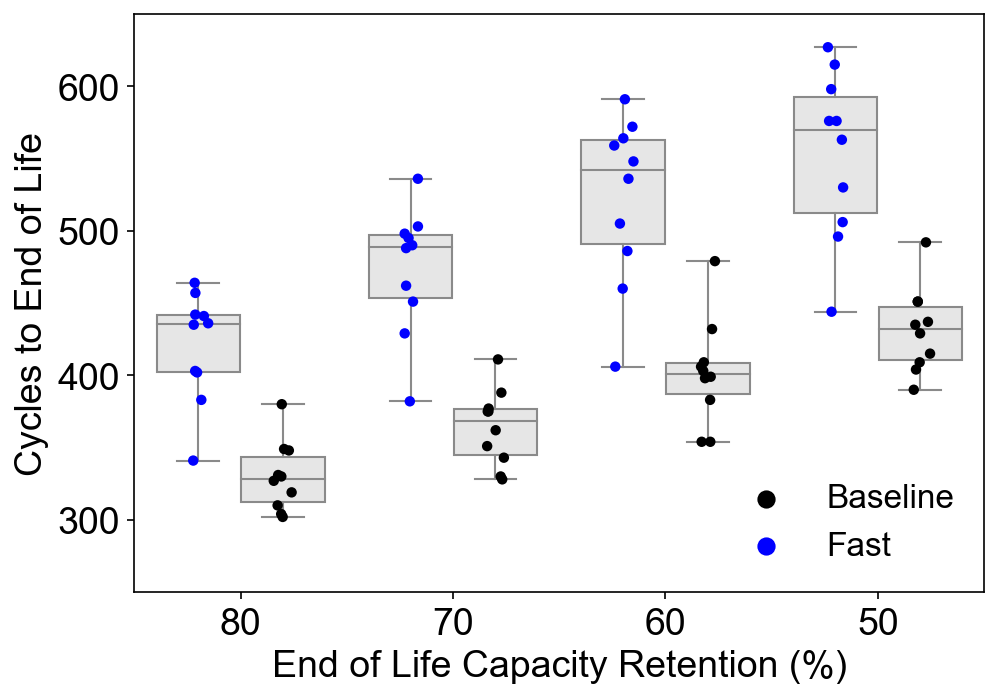

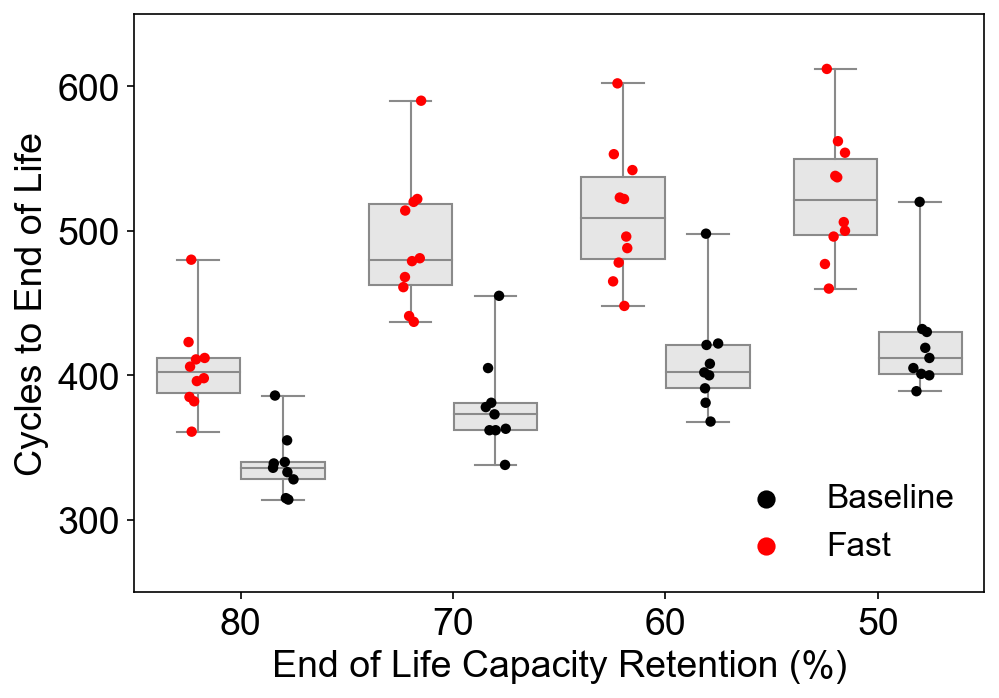

In [15]:
for data_df, color, color2 in zip([df_room_temp, df_high_temp], 
                            [(0.8, 0.8, 1), (1, 0.8, 0.8)],
                            ['b', 'r']):
    
    plt.figure(figsize=(7,5))

    bp = sns.boxplot(x='retention', y='cycles',
                     data=data_df,
                     palette=[GREY, GREY],
                     hue='formation_type',
                     showfliers=False,
                     whis=1e9,
                     linewidth=1
                    )

    bp = sns.stripplot(x='retention', y='cycles', 
                       data=data_df, 
                       jitter=True,
                       dodge=True, 
                       marker='o',
                       palette=['black', color2],
                       hue='formation_type',
                       alpha=1)

    bp.invert_xaxis()
    
    bp.set(ylabel='Cycles to End of Life',
           xlabel='End of Life Capacity Retention (%)',
           title='',
           ylim=(250,650))

    ax = plt.gca()
    ax.grid(False)

    handles, labels = bp.get_legend_handles_labels()
    l = plt.legend(handles[2:4], ['Baseline', 'Fast'], 
                   prop={'size': 16}, 
                   frameon=False,
                   loc='lower right')

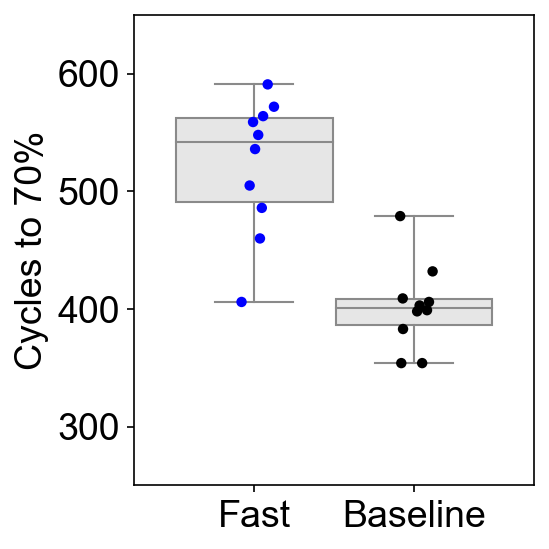

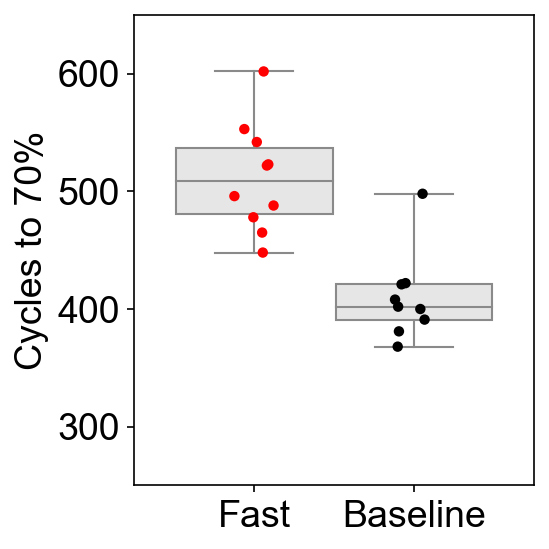

In [16]:
for data_df, color, color2 in zip([df_room_temp, df_high_temp], 
                            [(0.8, 0.8, 1), (1, 0.8, 0.8)],
                            ['b', 'r']):
    
    plt.figure(figsize=(4, 4))

    bp = sns.boxplot(x='retention', y='cycles',
                     data=data_df,
                     palette=[GREY, GREY],
                     hue='formation_type',
                     showfliers=False,
                     whis=1e9,
                     linewidth=1
                    ) 

    bp = sns.stripplot(x='retention', y='cycles', 
                       data=data_df, 
                       jitter=True,
                       dodge=True, 
                       marker='o',
                       palette=['black', color2],
                       hue='formation_type',
                       alpha=1)

    bp.invert_xaxis()
    
    bp.set(ylabel='Cycles to 70%',
           xlabel='',
           title='',
           ylim=(250,650),
           xlim=(1.5, 0.5))

    ax = plt.gca()
    ax.grid(False)
    
    ax.set_xticks([1.2, 0.80])
    ax.set_xticklabels(['Fast', 'Baseline'])
    plt.legend().remove()